In [1]:
%load_ext autoreload
%autoreload 2

from sklearn.cluster import AgglomerativeClustering
from src.utils import load_json
from src.similarity import calc_molecule_rcmcs, calc_rxn_rcmcs, extract_operator_patts, fractionate
from collections import defaultdict
import pandas as pd
import numpy as np
import scipy.sparse as sp
import rdkit
from rdkit import Chem
from rdkit.Chem import rdFMCS, AllChem, Draw
print(rdkit.__version__)
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
import re
from Bio import Align

2023.09.5


In [2]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# Calculating rcmcs

In [3]:
rxns = load_json("../data/sprhea/v3_folded_test.json")
rxns = {int(k) : v for k, v in rxns.items()}

In [4]:
rules = pd.read_csv(
    filepath_or_buffer='../data/sprhea/minimal1224_all_uniprot.tsv',
    sep='\t'
)
rules.set_index('Name', inplace=True)
rules.head()

,Reactants,SMARTS,Products,Comments
Name,,,,
rule0001,Any;Any,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],Any;Any,A0A060PLD9;A0A0P0YNP7;A0A0P9RZM9;A1XCQ0;A3E242...
rule0002,Any;NAD_CoF,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,NADH_CoF;Any,A0A023RBJ1;A0A060KZ16;A0A060TBM3;A0A072UJB3;A0...
rule0003,NADH_CoF;Any,[#6:1]1=[#6:2]-[#7:3]-[#6:4]=[#6:5]-[#6:6]-1.[...,Any;NAD_CoF,A0A023RBJ1;A0A060KZ16;A0A060TBM3;A0A072UJB3;A0...
rule0004,Any;NADH_CoF;O2,[#6:1].[#6:2]1=[#6:3]-[#7:4]-[#6:5]=[#6:6]-[#6...,Any;NAD_CoF;WATER,A0A1P8W705;A0A250DUW2;A1Z745;A5HMH6;A5HMH7;A5H...
rule0005,Any;NAD_CoF;WATER,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,Any;NADH_CoF;O2,A0A1P8W705;A0A250DUW2;A1Z745;A5HMH6;A5HMH7;A5H...


In [5]:
features = ["smarts", "rcs", "min_rules"]
data = defaultdict(list)
for k, v in rxns.items():
    data["id"].append(k)
    for feat in features:
        data[feat].append(v[feat])

X = pd.DataFrame(data=data)
X.set_index('id', inplace=True)

X.head(10)

,smarts,rcs,min_rules
id,,,
1760,C[S+](CCCN)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O.O=C=...,"[[[4], [1, 0]], [[4, 6, 8]]]","[rule0023, rule0024]"
404,NC(=O)OP(=O)(O)O.NCCCC(N)C(=O)O>>NC(=O)NCCCC(N...,"[[[1, 3], [0]], [[1, 3], [2]]]","[rule0098, rule0099]"
174,NC(=O)NC(CC(=O)O)C(=O)O>>O=C1CC(C(=O)O)NC(=O)N1.O,"[[[0, 6, 8]], [[1, 10], [0]]]","[rule0106, rule0111]"
128,C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)...,"[[[0, 1], [9]], [[14], [10, 9]]]","[rule0011, rule0010]"
743,NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4c...,"[[[3, 4, 5, 41, 42, 43], [1, 3]], [[1, 3], [3,...","[rule0003, rule0002]"
167,*CO.NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OC...,"[[[1, 2], [3, 4, 5, 6, 7, 43]], [[3, 4, 5, 41,...","[rule0002, rule0003]"
1873,*OC1C(COP(=O)(O)OC2C(COP(=O)(O)OC3C(COP(*)(=O)...,"[[[49, 5, 6]], [[5], [38, 39]]]","[rule0549, rule0550]"
85,Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O)C(O)C1...,"[[[21], [4, 5]], [[4], [22, 23]]]","[rule0014, rule0015]"
210,Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O)C(O)C1...,"[[[21], [8, 9]], [[8], [22, 23]]]","[rule0014, rule0015]"


In [6]:
rxn1 = X.loc[85, :].tolist()
rxn2 = X.loc[210, :].tolist()
rxn1[-1] = [extract_operator_patts(rules.loc[rxn1[-1][0], 'SMARTS'], i) for i in range(2)]
rxn2[-1] = [extract_operator_patts(rules.loc[rxn2[-1][0], 'SMARTS'], i) for i in range(2)]


1.0


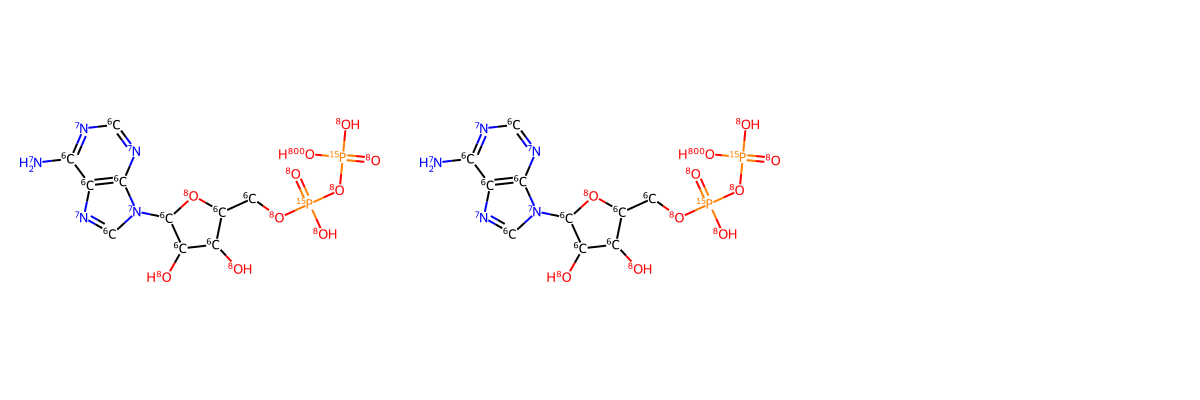

In [12]:
# Test molecule rcmcs (same molecule)

smi1 = fractionate(rxn1[0])[0]
smi2 = fractionate(rxn2[0])[0]
mol_rc1 = tuple([Chem.MolFromSmiles(smi1), rxn1[1][0][0]])
mol_rc2 = tuple([Chem.MolFromSmiles(smi2), rxn2[1][0][0]])
patt = rxn1[-1][0][0]


print(calc_molecule_rcmcs(mol_rc1, mol_rc2, patt, norm='max'))

Draw.MolsToGridImage((mol_rc1[0], mol_rc2[0]), subImgSize=(400, 400))

0.9230769230769231


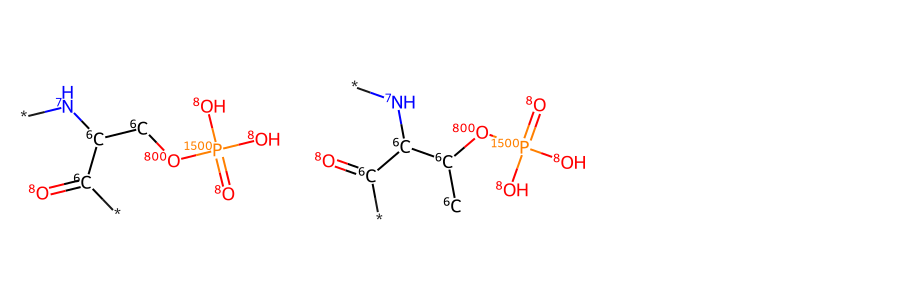

In [8]:
# Test molecule rcmcs (slightly different molecule)

smi1 = fractionate(rxn1[0])[1]
smi2 = fractionate(rxn2[0])[1]
mol_rc1 = tuple([Chem.MolFromSmiles(smi1), rxn1[1][0][1]])
mol_rc2 = tuple([Chem.MolFromSmiles(smi2), rxn2[1][0][1]])
patt = rxn1[-1][0][1]


print(calc_molecule_rcmcs(mol_rc1, mol_rc2, patt, norm='max'))

Draw.MolsToGridImage((mol_rc1[0], mol_rc2[0]), subImgSize=(300, 300))

In [9]:
# Test reaction rcmcs
calc_rxn_rcmcs(rxn1, rxn2)

0.975

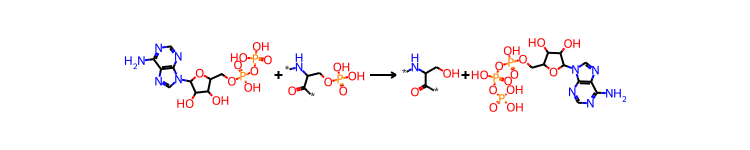

In [10]:
AllChem.ReactionFromSmarts(rxn1[0], useSmiles=True)

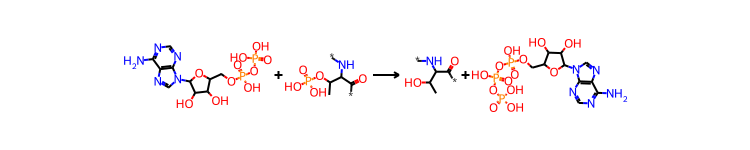

In [11]:
AllChem.ReactionFromSmarts(rxn2[0], useSmiles=True)

# There are distinct rules with equivalent smarts patts. Must pre-filter query pairs based on rule name

In [12]:
patts2rule = defaultdict(list)
for i, row in rules.iterrows():
    lhs = tuple(extract_operator_patts(row['SMARTS'], 0))
    rhs = tuple(extract_operator_patts(row['SMARTS'], 1))
    patts2rule[(lhs, rhs)].append(i)

In [13]:
for k,v in patts2rule.items():
    if len(v) > 1:
        print(k, v)

(('[#6]-[#8]', '[#8]'), ('[#6]-[#8]', '[#8]')) ['rule0001', 'rule0006', 'rule0007', 'rule0008', 'rule0009', 'rule0096', 'rule0097', 'rule0104', 'rule0105']
(('[#16]', '[#6]-[#8]'), ('[#6]-[#16+]', '[#8]')) ['rule0010', 'rule0405', 'rule0757']
(('[#6]-[#16+]', '[#8]'), ('[#16+0]', '[#6]-[#8]')) ['rule0011', 'rule0406', 'rule0758']
(('[#6]-[#8]', '[#7]'), ('[#6]-[#7]', '[#8]')) ['rule0012', 'rule0055', 'rule0098', 'rule0123', 'rule0163', 'rule0194', 'rule0429']
(('[#6]-[#7]', '[#8]'), ('[#6]-[#8]', '[#7]')) ['rule0013', 'rule0056', 'rule0099', 'rule0122', 'rule0162', 'rule0195', 'rule0430']
(('[#8]', '[#8]-[#15]'), ('[#8]', '[#8]-[#15]')) ['rule0014', 'rule0015', 'rule0016', 'rule0017', 'rule0029', 'rule0036', 'rule0037', 'rule0124', 'rule0125', 'rule0215', 'rule0216', 'rule0472', 'rule0473', 'rule0767', 'rule0768', 'rule1221', 'rule1222']
(('[#6]-[#6]-[#8]',), ('[#6]=[#6]', '[#8]')) ['rule0019', 'rule0461']
(('[#6]=[#6]', '[#8]'), ('[#6]-[#6]-[#8]',)) ['rule0020', 'rule0460']
(('[#16]',

# Compute distance matrix for test set

In [14]:
dist_i_to_rxn_idx = {i : idx for i, idx in enumerate(rxns.keys())}
rxn_idx_to_dist_i = {v : k for k, v in dist_i_to_rxn_idx.items()}
fields = ['smarts', 'rcs', 'min_rules']

S = np.eye(N=len(dist_i_to_rxn_idx)) # Similarity matrix

for i in range(len(dist_i_to_rxn_idx) - 1):
    rowi = [rxns[dist_i_to_rxn_idx[i]][f] for f in fields]
    for j in range(i + 1, len(dist_i_to_rxn_idx)):
        rowj = [rxns[dist_i_to_rxn_idx[j]][f] for f in fields]
        
        if tuple(rowi[2]) != tuple(rowj[2]): # Distinct minimal rules:
            rev_rules = rowj[2][::-1]

            if tuple(rowi[2]) != tuple(rev_rules):
                S[i, j] = 0.0 # Still distinct after reversing direction
                continue
            else: # Directions now match
                rowj[2] = rev_rules
                rowj[1] = rowj[1][::-1]
                rowj[0] = ">>".join(rowj[0].split('>>')[::-1])

        # Convert rule name -> patts
        anchor_rule = rowi[2][0]
        patts = [extract_operator_patts(rules.loc[anchor_rule, 'SMARTS'], side) for side in range(2)]
        rxn_rci = rowi[:2] + [patts]
        rxn_rcj = rowj[:2] + [patts]
        
        rcmcs = calc_rxn_rcmcs(rxn_rci, rxn_rcj)
        print(rcmcs)
        S[i, j] = rcmcs

D = 1 - S
D

0.9791666666666666
0.975


array([[0.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 0.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 0.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 0.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 0.        ,
        0.02083333, 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        0.        , 1.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.        , 1.        , 1.        , 1.        ],
       [1.        , 1.        , 1.       

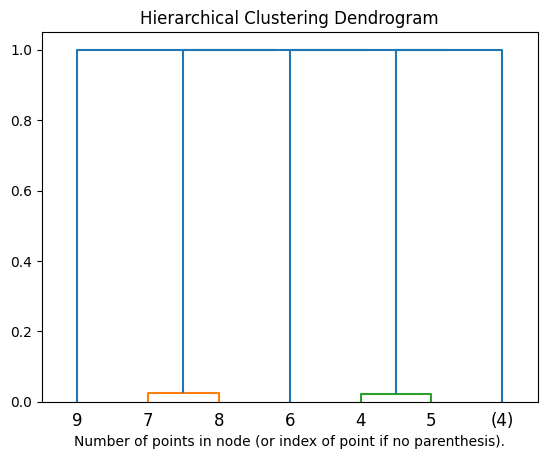

In [15]:
cutoff = 0 # To visualize full dendrogram
ac = AgglomerativeClustering(
    n_clusters=None,
    metric='precomputed',
    distance_threshold=cutoff,
    linkage='single'
    
)

ac.fit(D)

plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(ac, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [16]:
cutoff = 0.2 # To visualize full dendrogram
ac = AgglomerativeClustering(
    n_clusters=None,
    metric='precomputed',
    distance_threshold=cutoff,
    linkage='single'
    
)

ac.fit(D)
clabels = {rxn_idx : ac.labels_[rxn_idx_to_dist_i[rxn_idx]] for rxn_idx in rxn_idx_to_dist_i}
clabels

{1760: 7,
 404: 5,
 174: 6,
 128: 2,
 743: 1,
 167: 1,
 1873: 3,
 85: 0,
 210: 0,
 979: 4}

In [17]:
[rxn_idx for rxn_idx in rxn_idx_to_dist_i]
ac.labels_[rxn_idx_to_dist_i[1760]]

7

# Hierarchical clustering

In [126]:
D = np.array(
    [[0.0, 0.8, 0.7],
     [0.8, 0.0, 0.6],
     [0.7, 0.6, 0.0]]
)

D_triu = np.triu(D)
D_triu

array([[0. , 0.8, 0.7],
       [0. , 0. , 0.6],
       [0. , 0. , 0. ]])

In [127]:
cutoff = 0.2 # To visualize full dendrogram
ac = AgglomerativeClustering(
    n_clusters=None,
    metric='precomputed',
    distance_threshold=cutoff,
    linkage='single'
    
)

NameError: name 'plot_dendrogram' is not defined

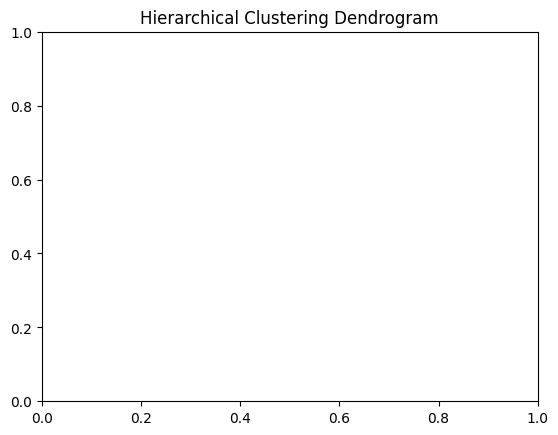

In [128]:
ac.fit(D)

plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(ac, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [129]:
ac.labels_

array([1, 2, 0])

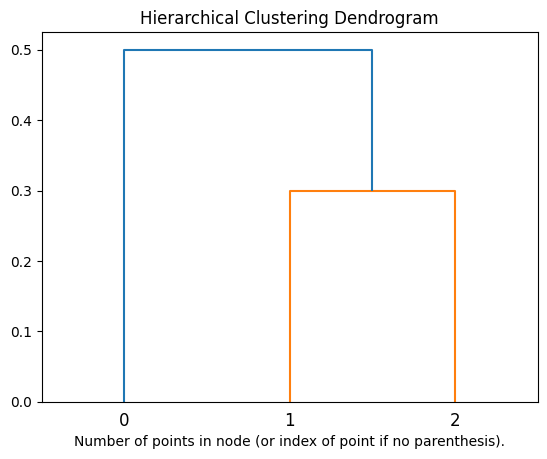

In [21]:
ac.fit(D_triu)

plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(ac, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

# Troubleshoot rcmcs

0.125


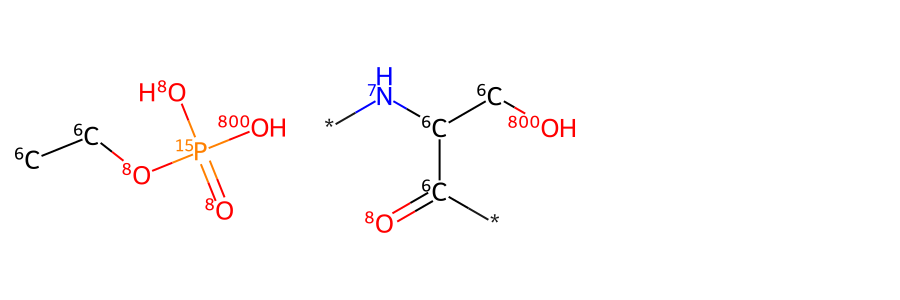

In [22]:
smiles = [
    'CCOP(=O)(O)O',
    '*NC(CO)C(*)=O'
]
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
rcs = [(6,), (4,)]
patt = '[800#8]'

mol_rc1, mol_rc2 = list(zip(mols, rcs))

print(calc_molecule_rcmcs(mol_rc1, mol_rc2, patt, norm='max'))
Draw.MolsToGridImage(mols, subImgSize=(300, 300))

0.14285714285714285


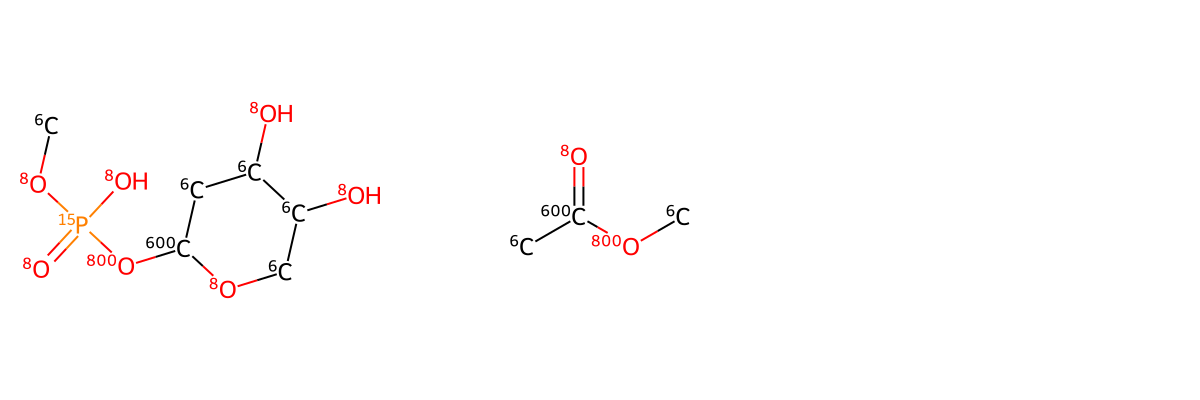

In [23]:
smiles = ['COP(=O)(O)OC3CC(O)C(O)CO3',
          'CC(=O)OC'
          ]
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
patt = '[600#6]-[800#8]'

rcs = [(5, 6), (1, 3)]

mol_rc1, mol_rc2 = list(zip(mols, rcs))

print(calc_molecule_rcmcs(mol_rc1, mol_rc2, patt, norm='max'))
Draw.MolsToGridImage(mols, subImgSize=(400, 400))

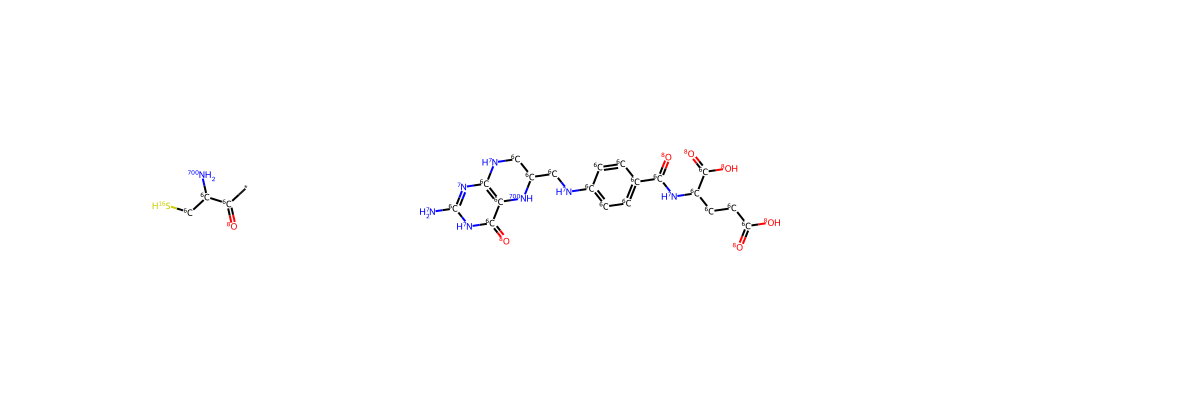

In [24]:
smiles = ['*[6C](=[8O])[6CH]([700NH2])[6CH2][16SH]',
          '[7NH2][6c]1[7n][6c]2[6c]([6c](=[8O])[7nH]1)[700NH][6CH]([6CH2][7NH][6c]1[6cH][6cH][6c]([6C](=[8O])[7NH][6CH]([6CH2][6CH2][6C](=[8O])[8OH])[6C](=[8O])[8OH])[6cH][6cH]1)[6CH2][7NH]2'
          ]
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
patt = '*[700#7]'
Draw.MolsToGridImage(mols, subImgSize=(400, 400))

In [25]:
res = rdFMCS.FindMCS(
        mols,
        seedSmarts=patt,
        atomCompare=rdFMCS.AtomCompare.CompareIsotopes,
        bondCompare=rdFMCS.BondCompare.CompareOrderExact,
        matchChiralTag=False,
        ringMatchesRingOnly=True,
        completeRingsOnly=False,
        matchValences=True,
        timeout=15
    )
print(res.smartsString)

[6*&!R](=&!@[8*&!R])-&!@[6*&!R]-&!@[6*&!R]


[08:51:06] The provided InitialSeed is not an MCS and will be ignored


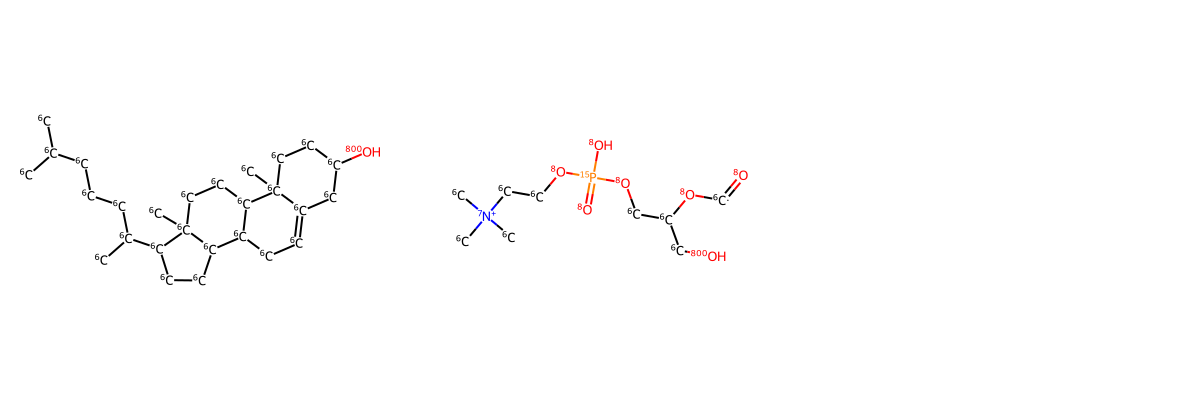

In [56]:
smiles = ['[6CH3][6CH]([6CH3])[6CH2][6CH2][6CH2][6CH]([6CH3])[6CH]1[6CH2][6CH2][6CH]2[6CH]3[6CH2][6CH]=[6C]4[6CH2][6CH]([800OH])[6CH2][6CH2][6C]4([6CH3])[6CH]3[6CH2][6CH2][6C]12[6CH3]',
          '[6C](=[8O])[8O][6CH]([6CH2][800OH])[6CH2][8O][15P](=[8O])([8OH])[8O][6CH2][6CH2][7N+]([6CH3])([6CH3])[6CH3]']
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
patt = '[800#8]'
Draw.MolsToGridImage(mols, subImgSize=(400, 400))


In [53]:
mols[0].GetAtomWithIdx(5).GetIsotope()

800

In [54]:
rc1 = [3, 5]
rc2 = [18, 17]
mol_rc1 = [mols[0], rc1]
mol_rc2 = [mols[1], rc2]
calc_molecule_rcmcs(mol_rc1, mol_rc2, patt)

0.16

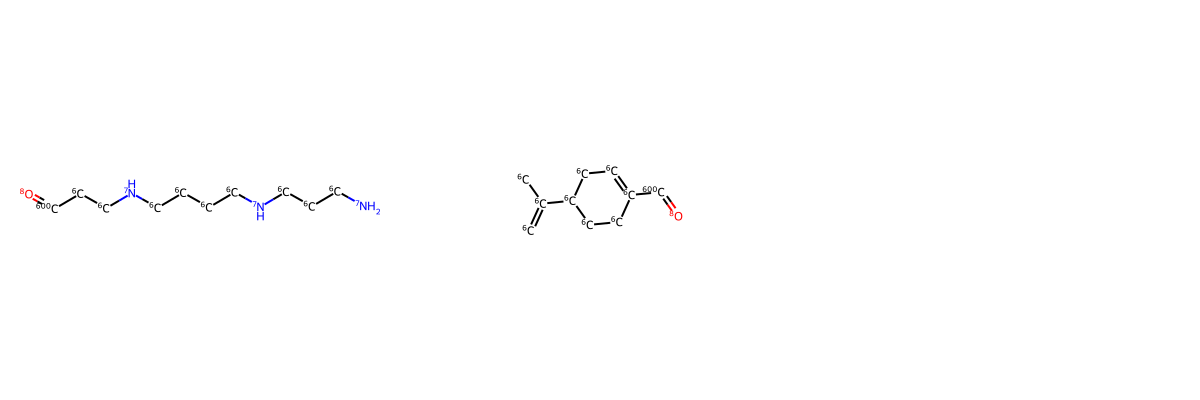

In [92]:
smiles = ['[7NH2][6CH2][6CH2][6CH2][7NH][6CH2][6CH2][6CH2][6CH2][7NH][6CH2][6CH2][600CH]=[8O]',
          '[6CH2]=[6C]([6CH3])[6CH]1[6CH2][6CH]=[6C]([600CH]=[8O])[6CH2][6CH2]1']
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
patt = '*~[600#6]'
Draw.MolsToGridImage(mols, subImgSize=(400, 400))

In [93]:
mols[0].GetAtomWithIdx(13).GetFormalCharge(), mols[1].GetAtomWithIdx(8).GetFormalCharge()

(0, 0)

In [94]:
res = rdFMCS.FindMCS(
        mols,
        seedSmarts=patt,
        atomCompare=rdFMCS.AtomCompare.CompareIsotopes,
        bondCompare=rdFMCS.BondCompare.CompareOrderExact,
        matchChiralTag=False,
        ringMatchesRingOnly=True,
        completeRingsOnly=False,
        matchValences=True,
        timeout=15
    )
res.smartsString

'[8*&!R]=&!@[600*&!R]'

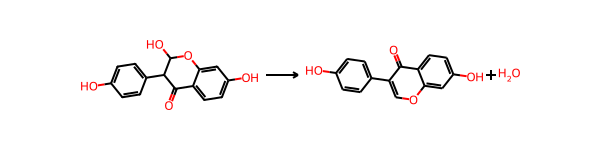

In [60]:
AllChem.ReactionFromSmarts('O=C1c2ccc(O)cc2OC(O)C1c1ccc(O)cc1>>O=c1c(-c2ccc(O)cc2)coc2cc(O)ccc12.O', useSmiles=True)

In [35]:
eg = '[800#8:1]:[600#6:2]'
bond_patt = r'(?<=\]{1})(\d?[-=:#]\d?)(?=\[{1})'
re.split(bond_patt, eg)

['[800#8:1]', ':', '[600#6:2]']

In [38]:
bond_patt = r'(?<=\]{1})(.)(?=\[{1})'
bond_patt = r'(?<=\]{1})(\d?[-=:#]\d?)(?=\[?)'

for i, row in rules.iterrows():
    for j in range(2):
        patts = extract_operator_patts(row['SMARTS'], j)
        for patt in patts:
            print(re.split(bond_patt, patt))

['[#6]', '-', '[#8]']
['[#8]']
['[#6]', '-', '[#8]']
['[#8]']
['[#6]', '-', '[#8]']
['[#6]', '1:', '[#6]', ':', '[#6]', ':', '[#6]', ':', '[#7+]', ':', '[#6]', ':1', '']
['[#6]', '1=', '[#6]', '-', '[#7+0]', '-', '[#6]', '=', '[#6]', '-', '[#6]', '-1', '']
['[#6]', '=', '[#8]']
['[#6]', '1=', '[#6]', '-', '[#7]', '-', '[#6]', '=', '[#6]', '-', '[#6]', '-1', '']
['[#6]', '=', '[#8]']
['[#6]', '-', '[#8]']
['[#6]', '1:', '[#6]', ':', '[#6]', ':', '[#6]', ':', '[#7+]', ':', '[#6]', ':1', '']
['[#6]']
['[#6]', '1=', '[#6]', '-', '[#7]', '-', '[#6]', '=', '[#6]', '-', '[#6]', '-1', '']
['[#8]', '=', '[#8]']
['[#6]', '-', '[#8]']
['[#6]', '1:', '[#6]', ':', '[#6]', ':', '[#6]', ':', '[#7+]', ':', '[#6]', ':1', '']
['[#8]']
['[#6]', '-', '[#8]']
['[#6]', '1:', '[#6]', ':', '[#6]', ':', '[#6]', ':', '[#7+]', ':', '[#6]', ':1', '']
['[#8]']
['[#6]']
['[#6]', '1=', '[#6]', '-', '[#7+0]', '-', '[#6]', '=', '[#6]', '-', '[#6]', '-1', '']
['[#8]', '=', '[#8]']
['[#6]', '-', '[#8]']
['[#8]']
['[#6]'

# Examples for subgroup

In [44]:
from IPython.display import display
from rdkit.Chem.Draw import IPythonConsole

draw_options = IPythonConsole.drawOptions
draw_options.setHighlightColour((0.5, 1.0, 0.5, 1.0))

def draw_highlight_pair(smiles, hilite_idxs, img_size=(400, 400), draw_options=draw_options):

    img = Draw.MolsToGridImage(
        mols=[Chem.MolFromSmiles(smi) for smi in smiles],
        highlightAtomLists=hilite_idxs,
        subImgSize=img_size
    )
    display(img)

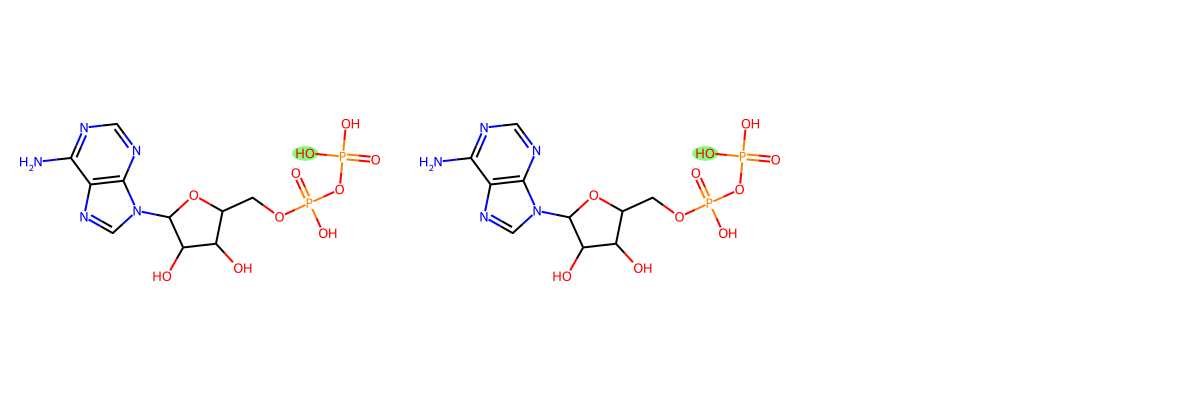

In [48]:
# Identical molecules, single atom reaction center pattern

smiles = [
    'Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O)C(O)C1O',
    'Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O)C(O)C1O',
]

rcs = [
    [21],
    [21],
]

draw_highlight_pair(smiles, rcs)

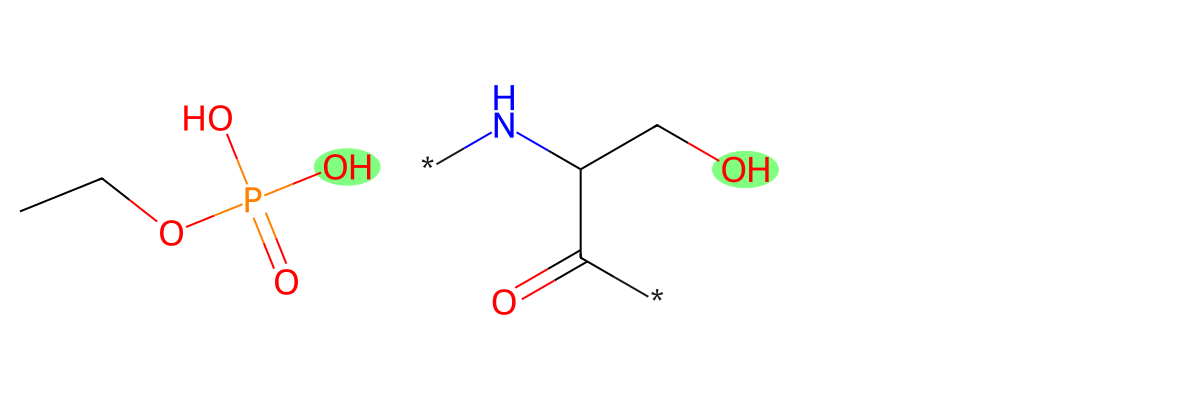

In [49]:
# Single atom reaction pair, different neighbors

smiles = [
    'CCOP(=O)(O)O',
    '*NC(CO)C(*)=O'
    ]
rcs = [(6,), (4,)]
draw_highlight_pair(smiles, rcs)

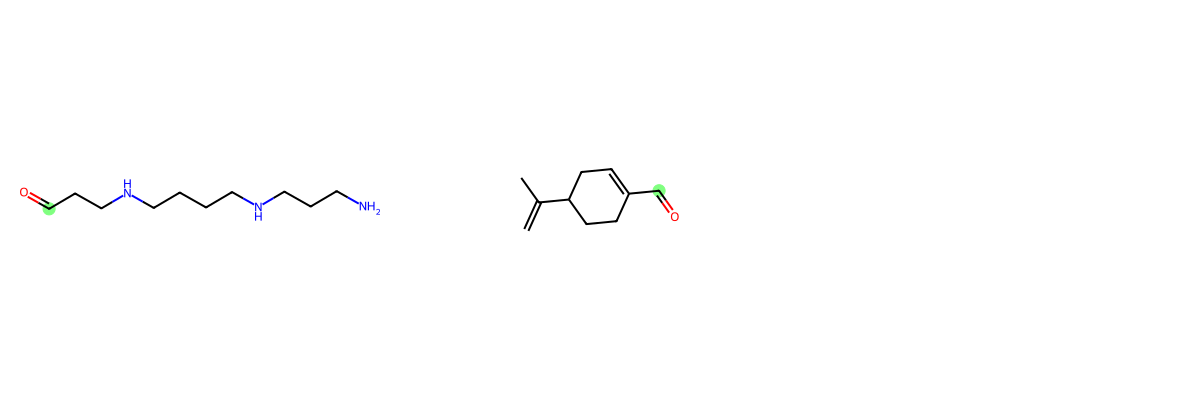

In [55]:
# Single atom reaction center, same neighbor, different bond type in between

smiles = ['NCCCNCCCCNCCC=O',
          'C=C(C)C1CC=C(C=O)CC1'
        ]
rcs = [(12,), (7,)]
draw_highlight_pair(smiles, rcs)

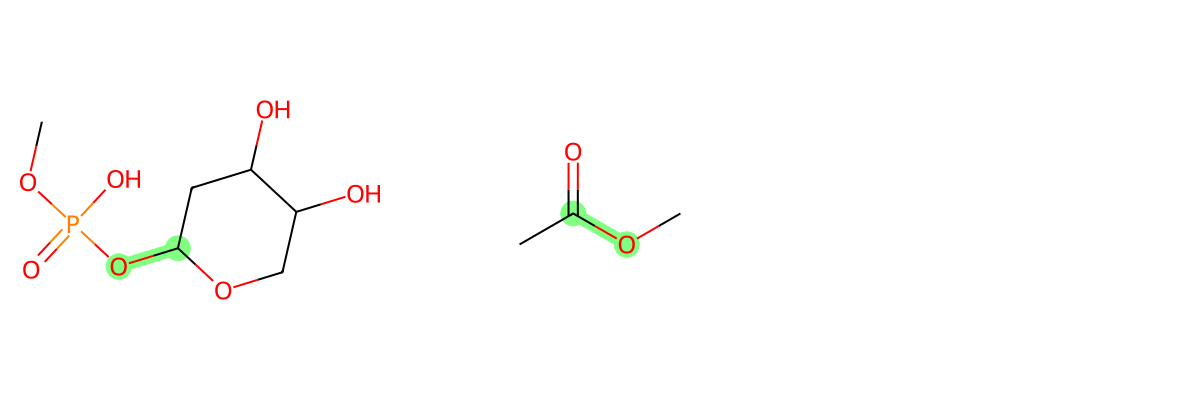

In [56]:
# Two-atom reaction center where one molecule
# matches with a ring-C, the other a linear C

smiles = ['COP(=O)(O)OC3CC(O)C(O)CO3',
          'CC(=O)OC'
        ]
patt = '[#6]-[#8]'
rcs = [(5, 6), (1, 3)]
draw_highlight_pair(smiles, rcs)

# Sequence alignment

In [108]:
toc = pd.read_csv(
    filepath_or_buffer='/home/stef/hiec/data/sprhea/v3_folded_test.csv',
    sep='\t'
)
toc.head()

,Entry,Label,Sequence
0,O04009,1760,MDSALPVSAIGFEGFEKRLEISFFEPGLFADPNGKGLRSLSKAQLD...
1,P11727,404,MAFNIHNRNLLSLEHHTNRELRYLLDLTRDLKAK
2,P20051,174,MVQEIDLGLTCDMHVHVREGAMCELVTPKIRDGGVSIAYIMPNLQP...
3,Q43209,128,MAQFWAEGSLEKNNALVEYLKQYGVVRTDKVAEVMETIDRALFVPE...
4,P42328,743;167,MKAAVVEQFKEPLKIKEVEKPTISYGEVLVRIKACGVCHTDLHAAH...


In [109]:
seqs = toc['Sequence'].tolist()

In [110]:
aligner = Align.PairwiseAligner(
    mode='local',
    scoring="blastp"
)

print(aligner)

Pairwise sequence aligner with parameters
  substitution_matrix: <Array object at 0x7fee1a2125d0>
  target_internal_open_gap_score: -12.000000
  target_internal_extend_gap_score: -1.000000
  target_left_open_gap_score: -12.000000
  target_left_extend_gap_score: -1.000000
  target_right_open_gap_score: -12.000000
  target_right_extend_gap_score: -1.000000
  query_internal_open_gap_score: -12.000000
  query_internal_extend_gap_score: -1.000000
  query_left_open_gap_score: -12.000000
  query_left_extend_gap_score: -1.000000
  query_right_open_gap_score: -12.000000
  query_right_extend_gap_score: -1.000000
  mode: local



In [111]:
'''
cd-hit default global sequence identity score

number of identical amino acids in alignment
divided by the full length of the shorter sequence
'''
def global_sequence_identity(seq1, seq2, aligner):
    alignment = aligner.align(seq1, seq2)[0]
    t_segments, q_segments = alignment.aligned
    assert t_segments.shape == q_segments.shape
    talign = ''
    qalign = ''
    for i in range(t_segments.shape[0]):
        talign += alignment.target[t_segments[i, 0] : t_segments[i, 1]]
        qalign += alignment.query[q_segments[i, 0] : q_segments[i, 1]]
    assert len(talign) == len(qalign)
    alignment.length
    ct = 0
    for t, q in zip(talign, qalign):
        if t == q:
            ct += 1

    return ct / min(len(alignment.target), len(alignment.query))

global_sequence_identity(seq1 = seqs[0], seq2=seqs[2], aligner=aligner)


0.01662049861495845

In [124]:
for i in range(len(seqs) - 1):
    for j in range(i, len(seqs)):
        print(global_sequence_identity(seq1 = seqs[i], seq2=seqs[j], aligner=aligner))

1.0
0.11764705882352941
0.01662049861495845
0.043478260869565216
0.014749262536873156
0.01662049861495845
0.013850415512465374
0.030211480362537766
0.01662049861495845
1.0
0.17647058823529413
0.08823529411764706
0.14705882352941177
0.17647058823529413
0.14705882352941177
0.11764705882352941
0.17647058823529413
1.0
0.021739130434782608
0.02654867256637168
0.04945054945054945
0.019230769230769232
0.02416918429003021
0.038461538461538464
1.0
0.0391304347826087
0.06521739130434782
0.021739130434782608
0.04782608695652174
0.06521739130434782
1.0
0.0471976401179941
0.014749262536873156
0.02416918429003021
0.029498525073746312
1.0
0.037122969837587005
0.0634441087613293
0.020771513353115726
1.0
0.027190332326283987
0.15081206496519722
1.0
0.015105740181268883


In [113]:
with open("/home/stef/hiec/artifacts/clustering/sprhea_v3_folded_pt_ns_80.clstr", "r") as f:
    lines = f.readlines()

In [114]:
cluster_patt = r'>Cluster \d+'
repr_patt = r'\s\*[\n]'
upid_patt = r'(?<=[>])(.+)(?=\.\.\.)'
cluster_n_patt = r'(?<=\s)(\d+)(?=[\n])'
seq_id_patt = r'\d+\.\d+'

current_cluster = None
clusters = {}
for line in lines:
    if re.match(cluster_patt, line):
        if current_cluster:
            clusters[current_cluster] = {'rep': representative, 'others': others}

        cn = re.search(cluster_n_patt, line).group()
        current_cluster = int(cn)
        representative = ''
        others = {}

    elif re.search(repr_patt, line):
        representative = re.search(upid_patt, line).group()

    else:
        seq_id = float(re.search(seq_id_patt, line).group()) / 100
        upid = re.search(upid_patt, line).group()
        others[upid] = seq_id

clusters = {k: v for k, v in clusters.items() if v['others']}

{6: {'rep': 'Q008X6', 'others': {'Q008X5': 0.9991}}, 10: {'rep': 'Q8NEZ4', 'others': {'Q8BRH4': 0.8545999999999999}}, 15: {'rep': 'Q03164', 'others': {'P55200': 0.9112}}, 16: {'rep': 'Q8B912', 'others': {'Q9WJB2': 0.9028, 'Q9YN02': 0.9023}}, 18: {'rep': 'Q96662', 'others': {'Q01499': 0.892}}, 20: {'rep': 'Q04561', 'others': {'A0MD28': 0.9549}}, 22: {'rep': 'Q96Q15', 'others': {'Q8BKX6': 0.9776}}, 26: {'rep': 'Q15772', 'others': {'Q63638': 0.9147, 'Q62407': 0.9145}}, 30: {'rep': 'Q0KL02', 'others': {'O75962': 0.9655, 'F1M0Z1': 0.9934999999999999}}, 32: {'rep': 'Q62388', 'others': {'Q13315': 0.841}}, 35: {'rep': 'O60229', 'others': {'A2CG49': 0.9764, 'P97924': 0.9784}}, 36: {'rep': 'Q9NR48', 'others': {'Q99MY8': 0.9216}}, 44: {'rep': 'Q9UMN6', 'others': {'O08550': 0.9056000000000001}}, 51: {'rep': 'Q13535', 'others': {'Q9JKK8': 0.9078}}, 53: {'rep': 'O15021', 'others': {'Q811L6': 0.8189}}, 58: {'rep': 'P42346', 'others': {'Q9JLN9': 0.9948999999999999, 'P42345': 0.9890000000000001}}, 61: 

In [103]:
X = []
y = []
for cluster in clusters.values():
    for upid in cluster['others']:
        X.append((cluster['rep'], upid))
        y.append(cluster['others'][upid])

In [119]:
toc = pd.read_csv(
    filepath_or_buffer='/home/stef/hiec/data/sprhea/v3_folded_pt_ns.csv',
    sep='\t'
).set_index('Entry')
toc.head()

,Label,Sequence
Entry,,
P0A6W3,1123,MLVWLAEHLVKYYSGFNVFSYLTFRAIVSLLTALFISLWMGPRMIA...
P9WMW7,1123,MRQILIAVAVAVTVSILLTPVLIRLFTKQGFGHQIREDGPPSHHTK...
O66465,1123,MLYQLALLLKDYWFAFNVLKYITFRSFTAVLIAFFLTLVLSPSFIN...
Q8MJ30,3097;7946,MAAAAAGEARRVLVYGGRGALGSRCVQAFRARNWWVASIDVVENEE...
P38489,3097;7946,MDIISVALKRHSTKAFDASKKLTPEQAEQIKTLLQYSPSSTNSQPW...


In [121]:
y_pred = []
for id1, id2 in X[:20]:
    seq1 = toc.loc[id1, 'Sequence']
    seq2 = toc.loc[id2, "Sequence"]
    y_pred.append(global_sequence_identity(seq1, seq2, aligner))

In [123]:
for elt in zip(y[:20], y_pred[:20]):
    print(elt)

(0.9991, 0.9991218441273326)
(0.8545999999999999, 0.8541709157658577)
(0.9112, 0.9117498739283914)
(0.9028, 0.9027777777777778)
(0.9023, 0.9022973996465539)
(0.892, 0.8919958953309389)
(0.9549, 0.9549244398124023)
(0.9776, 0.9775833788955713)
(0.9147, 0.9146977600490949)
(0.9145, 0.9144696505211527)
(0.9655, 0.9654504359057152)
(0.9934999999999999, 0.9935483870967742)
(0.841, 0.8422774869109948)
(0.9764, 0.9763832658569501)
(0.9784, 0.9783710713078743)
(0.9216, 0.9222447599729547)
(0.9056000000000001, 0.9067453004054552)
(0.9078, 0.9074003795066413)
(0.8189, 0.819327731092437)
(0.9948999999999999, 0.994899960768929)
